In [38]:
#import modules
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [6]:
#defining directories
BASE_DIR='flickr8k'
WORKING_DIR='working'

os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(WORKING_DIR, exist_ok=True)

In [7]:
#load and restructure model
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summarize
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
#extract features from image
features={}
directory=os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    #load image from file
    img_path=directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    #convert image to array
    image=img_to_array(image)
    #reshape
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess
    image=preprocess_input(image)
    #extract features
    feature=model.predict(image, verbose=0)
    #get img ID
    image_id=img_name.split('.')[0]
    #store features
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [179]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [180]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [11]:
#load captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc=f.read()

In [84]:
#mapping image to caption
mapping={}
#process lines
for line in tqdm(captions_doc.split('\n')):
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id, caption=tokens[0], tokens[1:]
    image_id=image_id.split('.')[0]
    caption="".join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [85]:
len(mapping)

8091

In [86]:
#preprocessing captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            #delete digits,special characters etc
            caption=caption.replace('[^A-Za-z]', '')
            #delete extra spaces 
            caption=caption.replace('\s+', ' ')
            #add start and end tags
            caption='startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i]=caption

In [87]:
#before preprocessing
mapping['667626_18933d713e']

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 '"A young girl is lying in the sand  while ocean water is surrounding her ."',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [88]:
#preprocess
clean(mapping)

In [89]:
#after preprocessing
mapping['667626_18933d713e']

['startseq girl is stretched out in shallow water endseq',
 'startseq girl wearing red and multi-colored bikini is laying on her back in shallow water endseq',
 'startseq little girl in red swimsuit is laying on her back in shallow water endseq',
 'startseq "a young girl is lying in the sand while ocean water is surrounding her ." endseq',
 'startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq']

In [90]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [91]:
len(all_captions)

40455

In [92]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [107]:
#tokenize text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index) + 1

In [182]:
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))

In [183]:
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'rb') as tokenizer_file:
    tokenizer=pickle.load(tokenizer_file)

In [94]:
vocab_size

8485

In [95]:
#get maximum length of caption availabel
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [96]:
#Train-Test Split
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
split

7281

In [97]:
train=image_ids[:split]
test=image_ids[split:]

In [98]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {'image': X1, 'text': X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [99]:
# Explains what the above data generator is doing
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq


In [100]:
#Model Creation

#encoder
#image features layer
inputs1=Input(shape=(4096,), name="image")
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256, activation='relu')(fe1)
#sequence feature layers
inputs2=Input(shape=(max_length,), name="text")
se1=Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)


#decoder
decoder1=add([fe2, se3])
decoder2=Dense(256, activation='relu')(decoder1)
outputs=Dense(vocab_size, activation='softmax')(decoder2)


model=Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot model
# plot_model(model, show_shapes=True)

In [101]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - loss: 5.7596
227/227 ━━━━━━━━━━━━━━━━━━━━ 885s 4s/step - loss: 4.0674
227/227 ━━━━━━━━━━━━━━━━━━━━ 894s 4s/step - loss: 3.5923
227/227 ━━━━━━━━━━━━━━━━━━━━ 892s 4s/step - loss: 3.3131
227/227 ━━━━━━━━━━━━━━━━━━━━ 906s 4s/step - loss: 3.1091
227/227 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - loss: 2.9578
227/227 ━━━━━━━━━━━━━━━━━━━━ 889s 4s/step - loss: 2.8423
227/227 ━━━━━━━━━━━━━━━━━━━━ 882s 4s/step - loss: 2.7524
227/227 ━━━━━━━━━━━━━━━━━━━━ 915s 4s/step - loss: 2.6663
227/227 ━━━━━━━━━━━━━━━━━━━━ 914s 4s/step - loss: 2.5933
227/227 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - loss: 2.5282
227/227 ━━━━━━━━━━━━━━━━━━━━ 843s 4s/step - loss: 2.4680
227/227 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - loss: 2.4162
227/227 ━━━━━━━━━━━━━━━━━━━━ 909s 4s/step - loss: 2.3692
227/227 ━━━━━━━━━━━━━━━━━━━━ 1174s 5s/step - loss: 2.3318
227/227 ━━━━━━━━━━━━━━━━━━━━ 1168s 5s/step - loss: 2.2937
227/227 ━━━━━━━━━━━━━━━━━━━━ 1363s 6s/step - loss: 2.2572
227/227 ━━━━━━━━━━━━━━━━━━━━

In [188]:
model.save(WORKING_DIR+'/PixelPhrase.keras')

In [103]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [123]:
#generate caption for img
def predict_caption(model, image, tokenixer, max_length):
    #start tag
    in_text = 'startseq'
    #iterating over max length
    for i in range(max_length):
        #encode input
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad sequence
        sequence=pad_sequences([sequence], max_length)
        #next word
        yhat=model.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat=np.argmax(yhat)
        #convert index to word
        word=idx_to_word(yhat, tokenizer)
        #stop if no word ahead
        if word is None:
            break
        #append found word for predicting next word
        in_text+=' ' + word
        #terminate loop when reach endseq
        if word=='endseq':
            break
    return in_text

In [133]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions=mapping[key]
    y_pred=predict_caption(model, features[key], tokenizer, max_length)
    actual_captions=[caption.split() for caption in captions]
    y_pred=y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0,0,0)))
print("BLEU-2: %F" % corpus_bleu(actual, predicted, weights=(0.5,0.5,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.534487
BLEU-2: 0.311849


In [134]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    img_path=os.path.join(BASE_DIR, 'Images', image_name)
    image=Image.open(img_path)
    captions=mapping[image_id]
    print('---------Actual----------')
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------Predicted--------') 
    print(y_pred)
    plt.imshow(image)

---------Actual----------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------Predicted--------
startseq two dogs are playing with plastic toy in the grass endseq


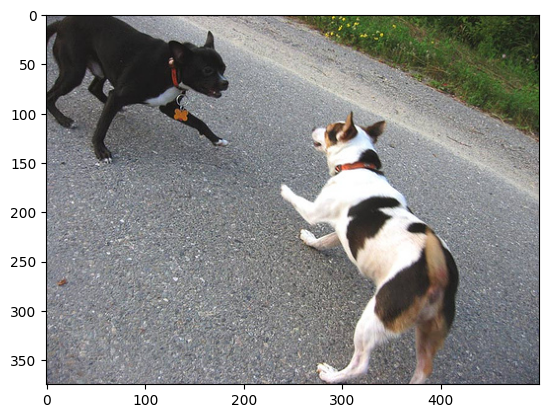

In [184]:
generate_caption('1001773457_577c3a7d70.jpg')

---------Actual----------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------Predicted--------
startseq little girl grips the red ropes endseq


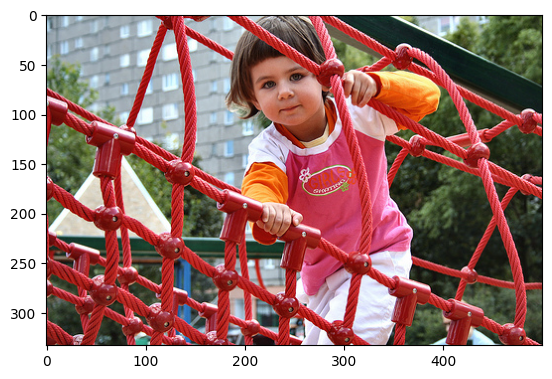

In [178]:
generate_caption('1007320043_627395c3d8.jpg')

---------Actual----------
startseq black and white dog drinking water from water spray endseq
startseq black and white dog is being soaked with jet of water in blue paddling pool endseq
startseq dog sticking its face into the shower from garden hose endseq
startseq small white dog gets sprayed by water endseq
startseq white and black dog is jumping into pool endseq
--------Predicted--------
startseq black and white dog is jumping into the water endseq


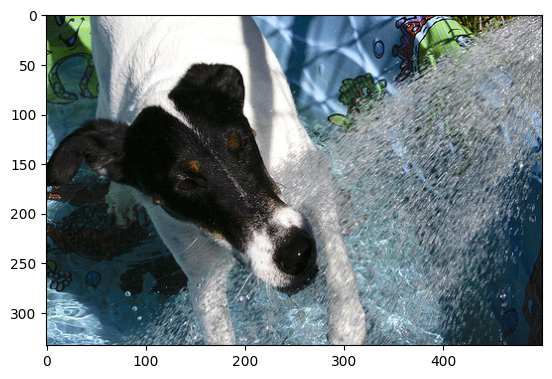

In [176]:
generate_caption('1096097967_ac305887b4.jpg')

---------Actual----------
startseq boy jumping in fountain endseq
startseq boy plays in the fountains endseq
startseq child plays in fountain endseq
startseq little boy playing in the water endseq
startseq young boy is jumping through water being sprayed up from the ground endseq
--------Predicted--------
startseq two boys are playing in park endseq


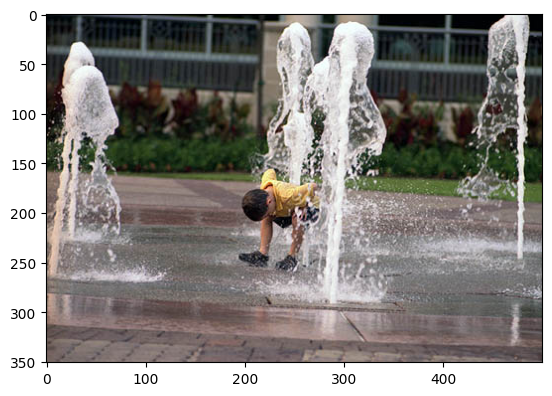

In [175]:
generate_caption('1095476286_87d4f8664e.jpg')

---------Actual----------
startseq boy smiles underwater endseq
startseq red-headed boy swimming underwater endseq
startseq small boy swimming underwater endseq
startseq smiling boy swims underwater in pool endseq
startseq the boys smiles underwater at the pool endseq
--------Predicted--------
startseq boy swimming underwater endseq


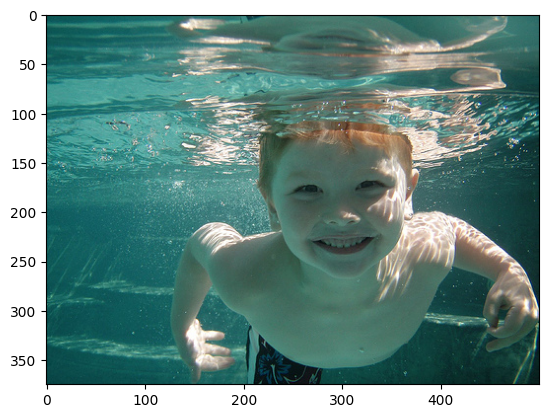

In [181]:
generate_caption('1096165011_cc5eb16aa6.jpg')

In [142]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [186]:
image_path="C:/Users/Rishi/OneDrive/Pictures/lh_wallpaper.png"
image=load_img(image_path, target_size=(224, 224))
image=img_to_array(image)
image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image=preprocess_input(image)
feature=vgg_model.predict(image, verbose=0)
predict_caption(model, feature, tokenizer, max_length)

'startseq man in black shirt is standing next to another man in black and white and white robot endseq'